In [3]:

# -*- coding: utf-8 -*-

# -- Sheet --

import pandas as pd 
import re
import os
import string
import csv
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

In [26]:
tweet_data = pd.read_csv("sentimenttweets.csv")
'''
# tweet_data = pd.concat([pd.read_excel(os.path.join("twitterdata", f), index_col = 0) for f in os.listdir("twitterdata")])

tweet_data = pd.read_csv("searchTweets.csv")

tweet_data = tweet_data[["ticker", "created", "sent_score"]]

tweet_data2 = tweet_data2[["ticker", "created", "sent_score"]]

tweet_data = pd.concat([tweet_data, tweet_data2], axis = 0)

tweet_data.shape

'''
print(tweet_data.head())


returns_data = pd.read_csv("stocks.csv")

returns_data.head()


  ticker                         created            id  polarity1 sentiment  \
0    MMM  Mon Apr 04 18:53:44 +0000 2022  1.510000e+18   0.106667  positive   
1    MMM  Mon Apr 04 16:55:27 +0000 2022  1.510000e+18   0.000000   neutral   
2    MMM  Mon Apr 04 16:00:46 +0000 2022  1.510000e+18   0.000000   neutral   
3    MMM  Mon Apr 04 14:30:00 +0000 2022  1.510000e+18   0.000000   neutral   
4    MMM  Fri Apr 01 14:48:13 +0000 2022  1.510000e+18   1.000000  positive   

   subjectivity1  polarity2  subjectivity2  
0       0.526667   0.106667       0.526667  
1       0.000000   0.000000       0.000000  
2       0.100000   0.000000       0.000000  
3       0.000000   0.000000       0.000000  
4       0.300000   1.000000       0.300000  


ticker    change
0    MMM -0.016707
1    AOS -0.012981
2    ABT -0.007476
3   ABBV -0.001954
4   ABMD -0.017808

In [5]:
tweet_agg = tweet_data.groupby(['ticker'],as_index=False).mean()
pd_data = tweet_agg.merge(returns_data)
pd_data

ticker            id  polarity1  subjectivity1  polarity2  subjectivity2  \
0        A  1.510000e+18   0.137614       0.277176   0.132364       0.272676   
1      AAL  1.510000e+18   0.092037       0.243148   0.055926       0.273704   
2      AAP  1.510000e+18   0.106667       0.526667   0.106667       0.526667   
3     AAPL  1.510000e+18   0.115024       0.333631   0.110274       0.360131   
4     ABBV  1.510000e+18   0.287140       0.296502   0.287140       0.285391   
..     ...           ...        ...            ...        ...            ...   
369    YUM  1.510000e+18   0.000000       0.000000   0.000000       0.000000   
370    ZBH  1.510000e+18   0.000000       0.000000   0.000000       0.000000   
371   ZBRA  1.510000e+18   0.000000       0.000000   0.000000       0.000000   
372   ZION  1.510000e+18   0.000000       0.000000   0.000000       0.000000   
373    ZTS  1.510000e+18   0.133333       0.222222   0.108333       0.222222   

       change  
0   -0.016241  
1   -0.011634  
2   -0.000425  
3   -0.015244  
4   -0.001954  
..        ...  
369  0.000759  
370 -0.000391  
371  0.022238  
372 -0.028829  
373  0.014794  

[374 rows x 7 columns]

In [6]:
pos_data = pd_data[pd_data['polarity2'] != 0]
pd_data.mean()

<ipython-input-6-6b05766f9d27>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd_data.mean()


id               1.510000e+18
polarity1        1.165467e-01
subjectivity1    2.577170e-01
polarity2        1.101422e-01
subjectivity2    2.584687e-01
change          -1.550989e-02
dtype: float64

In [7]:
def get_sent(row):
    if row[4] > 0:
        val = 'positive'
    elif row[4] < 0:
        val = 'negative'
    else:
        val = 'neutral'
    return val

In [8]:
pd_data['sentiment'] = pd_data.apply(get_sent, axis=1)
pd_data.groupby(['sentiment']).mean()

id  polarity1  subjectivity1  polarity2  subjectivity2  \
sentiment                                                                     
negative   1.510000e+18  -0.062723       0.225447  -0.071956       0.223206   
neutral    1.510000e+18   0.000410       0.061013   0.000000       0.061013   
positive   1.510000e+18   0.174855       0.308528   0.167576       0.309981   

             change  
sentiment            
negative  -0.020941  
neutral   -0.011511  
positive  -0.015467

In [9]:
pd_data['sentiment'].value_counts()

positive    266
neutral      61
negative     47
Name: sentiment, dtype: int64

# Top 20 results


In [34]:
neg_data = pd_data.sort_values('polarity2').head(20)
pos_data = pd_data.sort_values('polarity2').tail(20)
print(pos_data.groupby(['sentiment']).mean())
print(neg_data.groupby(['sentiment']).mean())

                     id  polarity1  subjectivity1  polarity2  subjectivity2  \
sentiment                                                                     
positive   1.510000e+18   0.565729       0.319644   0.566087       0.316099   

             change  
sentiment            
positive  -0.025616  
                     id  polarity1  subjectivity1  polarity2  subjectivity2  \
sentiment                                                                     
negative   1.510000e+18  -0.122979       0.273028  -0.133278       0.270556   

             change  
sentiment            
negative  -0.015116  


In [10]:
target = pd_data['change']
features = pd_data[['polarity2','subjectivity2']]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0, test_size = 0.2)

# LinearRegressor

In [25]:
lr = LinearRegression()
lr = lr.fit(X_train, y_train)

prediction = lr.predict(X_test)

mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)

print("\nThe model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(np.sqrt(mse)))
print('R2 is {}'.format(r2))

print("\n")

y_pred = cross_val_predict(LinearRegression(), features, target, cv=5)
mse = mean_squared_error(target, y_pred)
r2 = r2_score(target, y_pred)

print("\nThe model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('RMSE is {}'.format(np.sqrt(mse)))
print('R2 is {}'.format(r2))

print("\n")


The model performance for training set
--------------------------------------
MSE is 0.0009550571763899632
RMSE is 0.030903999359143845
R2 is -0.002849509995327848



The model performance for training set
--------------------------------------
MSE is 0.0013725925083551357
RMSE is 0.03704851560258705
R2 is -0.017075084915006755




In [23]:
std_target = target.std()
std_target

0.03678541749955388

# KNRegression

In [13]:
# KNN Regression
knn = KNeighborsRegressor()
neighbors = list(range(1,51))

param_grid = dict(n_neighbors = neighbors)
knn_grid = GridSearchCV(knn, param_grid, cv=10)

knn_grid.fit(features, target)
y_pred = list(knn_grid.predict(features))
knn_grid.score(features, target) 
knn_grid.best_params_

{'n_neighbors': 50}

Text(0, 0.5, 'Mean Squared Error')

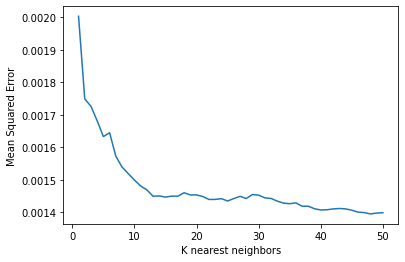

In [14]:
# Graphing the MSE for each hyperparameter
error = []
for k in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred = cross_val_predict(knn, features, target, cv=5)
    error.append(mean_squared_error(target,y_pred))
plt.plot(range(1,51),error)
plt.xlabel('K nearest neighbors')
plt.ylabel('Mean Squared Error')

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred

array([-0.02125373, -0.03914121, -0.01200583, -0.05635262, -0.02359806,
       -0.03106053, -0.00456412, -0.01506949, -0.05979041, -0.00798179,
       -0.04335015, -0.02673347, -0.02823816, -0.01326887,  0.06532686,
       -0.00506173, -0.02701899, -0.02880055, -0.01174149, -0.00547061,
       -0.01174149, -0.02043181, -0.01174149, -0.02032468, -0.01650705,
       -0.03895151, -0.00456412, -0.03728093, -0.02781669, -0.02664779,
       -0.0085469 , -0.01200583, -0.01174149, -0.00791325, -0.02043181,
       -0.05635262, -0.02249233, -0.0400486 , -0.01493781, -0.01200583,
       -0.02328165, -0.0195637 ,  0.01345978, -0.02036604,  0.0023257 ,
       -0.00544492, -0.01174149, -0.01200583, -0.01200583, -0.0212685 ,
        0.00908404, -0.0480402 , -0.00501609, -0.0097628 , -0.0364424 ,
       -0.02043181, -0.01200583, -0.01200583, -0.02662048, -0.03102915,
       -0.02359806, -0.01290213, -0.02842675, -0.01200583, -0.01531194,
       -0.01858946,  0.00804215, -0.01200583,  0.00191172, -0.00

In [16]:
mean_squared_error(y_test, y_pred)
np.sqrt(mean_squared_error(y_test, y_pred))

0.03517969124481711

In [ ]:


import random

random.seed(0)

train_tickers = list(random.sample(list(dt.index.get_level_values(0).unique()), 400))
test_tickers = [x for x in dt.index.get_level_values(0).unique() if x not in train_tickers]

import numpy as np 

X_train = np.array([features[features.index.get_level_values(0) == ticker].values.tolist() for ticker in train_tickers])
y_train = np.array([target[target.index.get_level_values(0) == ticker].values.tolist() for ticker in train_tickers])

X_test = np.array([features[features.index.get_level_values(0) == ticker].values.tolist() for ticker in test_tickers])
y_test = np.array([target[target.index.get_level_values(0) == ticker].values.tolist() for ticker in test_tickers])

X_test[1]




In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units = 5))
model.add(Dense(units = 1))

early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

model.compile(optimizer = "adam", loss = "mean_squared_error")

model.fit(X_train, y_train, epochs = 50, batch_size = 30, callbacks=[early_stop])

model.summary()

y_test_pred = model.predict(X_test)

y_test_pred


In [ ]:


import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred)
plt.show()

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_test_pred))

preds = pd.DataFrame({"Predicted": y_test_pred.flatten(), "Actual": y_test.flatten()})
preds.plot()

results = pd.DataFrame({"Predicted": y_test_pred.flatten(), "Actual": y_test.flatten()}, index = test_tickers)

results.head()

t_0 = features[features.index.get_level_values(1) == '11/25/2020'][["return", "sent_score"]].reset_index(level = 1)

res = results.merge(t_0, how = "left", left_index = True, right_index = True)

res.rename(columns = {"return": "t-1"}, inplace = True)
res.drop(columns = ["date"], inplace = True)

res.head()

ups = res[res["Predicted"] > res["t-1"]]

downs = res[res["Predicted"] < res["t-1"]]

In [ ]:

print("Ups: {} Downs: {}".format(ups.shape[0], downs.shape[0]))

print("Out of {} predicted ups, {} actually went up".format(ups.shape[0], res[(res["Predicted"] > res["t-1"]) & (res["Actual"] > res["t-1"])].shape[0]))

print("Out of {} predicted downs, {} actually went down".format(downs.shape[0], res[(res["Predicted"] < res["t-1"]) & (res["Actual"] < res["t-1"])].shape[0]))

abs_up_ret = (ups["Actual"] - ups["t-1"]).sum()
print("If we bought equally-weighted shares of each predicted up, we would have made: {:.2f}".format(abs_up_ret))
print("Of a total investment of {:.2f}, that's a 1-day return of {:.2f}%".format(ups["t-1"].sum(), abs_up_ret / ups["t-1"].sum() * 100))
print("Annualized, that figure is {:.2f}%".format((np.power(1 + abs_up_ret / ups["t-1"].sum(), 251) - 1) * 100))

abs_down_ret = (downs["t-1"] - downs["Actual"]).sum()
print("If we shorted equally-weighted shares of each predicted down, we would have made: {:.2f}".format(abs_down_ret))
print("Of a total investment of {:.2f} (@150% margin), that's a 1-day return of {:.2f}%".format(downs["t-1"].sum() * 1.5, abs_down_ret / (downs["t-1"].sum() * 1.5) * 100))
print("Annualized, that figure is {:.2f}%".format((np.power(1 + abs_down_ret / (downs["t-1"].sum() * 1.5), 251) - 1) * 100))

# Impact of sentiment on performance

top_sent = res.nlargest(20, columns = "sent_score")
low_sent = res.nsmallest(20, columns = "sent_score")

print("Of 20 companies with highest sentiment at t-1, {} went up, {} went down".format(top_sent[top_sent["Actual"] > top_sent["t-1"]].shape[0], top_sent[top_sent["Actual"] < top_sent["t-1"]].shape[0]))

print("Equal-weighted price return (long highest sentiment companies): {:.2f}".format((top_sent["Actual"] - top_sent["t-1"]).sum()))

print("Of 20 companies with lowest sentiment at t-1, {} went up, {} went down".format(low_sent[low_sent["Actual"] > low_sent["t-1"]].shape[0], low_sent[low_sent["Actual"] < low_sent["t-1"]].shape[0]))

print("Equal-weighted price return (short lowest sentiment companies): {:.2f}".format((low_sent["t-1"] - low_sent["Actual"]).sum()))

tr = (top_sent["Actual"] - top_sent["t-1"]).sum() + (low_sent["t-1"] - low_sent["Actual"]).sum()
print("Strategy: Long Top 20 Sentiment, Short Worst 20 Sentiment")
print("Net price return: {:.2f}".format(tr))
print("Net 1-day : {:.2f}%\nAnnualized: {:.2f}%".format(100 * tr / (top_sent["t-1"].sum() + 1.5 * low_sent["t-1"].sum()), (np.power(1 + tr / (top_sent["t-1"].sum() + 1.5 * low_sent["t-1"].sum()), 251) - 1) * 100))
